SCRAPEO IDEA CLASIFICACION

In [6]:
import re
import os
import ast
import json
import pickle
import folium
import requests
import numpy as np
import pandas as pd
from time import sleep
import plotly.express as px
from selenium import webdriver
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from selenium.webdriver.common.by import By

### DATOS CARGADORES

In [ ]:
api_url = "https://api.openchargemap.io/v3/poi/?output=json&countrycode=ES&maxresults=10000000&key=749b4a66-d261-432f-8ce2-75ab8fe9b0e7"
response = requests.get(api_url)
data = response.json()

In [ ]:
title,addresLine1,addresLine2,town,postcode,latitude,longitude,usageCost = [],[],[],[],[],[],[],[]
cargadores = []
cargadores2 = []
#lista de diccionarios con los puntos de carga y sus caracteristicas
num = 1 
for i in range(0,len(data)):
    title.append(data[i]['AddressInfo']['Title'])
    addresLine1.append( data[i]['AddressInfo']['AddressLine1'])
    addresLine2.append( data[i]['AddressInfo']['AddressLine2'])
    town.append(data[i]['AddressInfo']['Town'])
    postcode.append(data[i]['AddressInfo']['Postcode'])
    latitude.append(data[i]['AddressInfo']['Latitude'])
    longitude.append(data[i]['AddressInfo']['Longitude'])
    try:
        usageCost.append(data[i]['UsageCost'])
    except:
        usageCost.append(np.nan)
    num = 1

    for h in range(0, len(data[i]['Connections'])):
        dic = {}
        dic['formalName'] = data[i]['Connections'][h]['ConnectionType']['FormalName'],
        dic['title'] = data[i]['Connections'][h]['ConnectionType']['Title']
        try:
            dic['energia'] = data[i]['Connections'][h]['Level']['Comments']
        except:
            dic['energia'] = np.nan
        try:
            dic['isFastChargeCapable'] = data[i]['Connections'][h]['Level']['IsFastChargeCapable']
        except:
            dic['isFastChargeCapable'] = np.nan
        cargadores2.append(dic)
        
    cargadores.append(cargadores2)
    cargadores2 = []

In [ ]:
df_cargadores = pd.DataFrame({"title":title, "addressLine1":addresLine1,"addressLine2":addresLine2,"town":town,"postcode":postcode,"latitude":latitude,"longitude":longitude,"cargadores":cargadores,"usageCost":usageCost})

In [ ]:
df_cargadores.to_csv("df_cargadores.csv", index=False)

### EDA

In [17]:
df_coches = pd.read_csv("Data/df_coches_escrapeo.csv")

In [18]:
df_coches = df_coches[(df_coches["MTMA (Kg)"] > 400) & (df_coches["MTMA (Kg)"] < 3000)]
df_coches = df_coches[df_coches["Motorización"].notnull()]

In [19]:
df_coches.reset_index(inplace =True, drop=True)

UNIFICAR DATOS SIMILARES

In [20]:
df_coches.loc[df_coches["Motorización"] == "Gases licuados del petróleo (GLP)", "Motorización"] = "Gas natural"

In [21]:
df_coches = df_coches[~(df_coches["Motorización"] == "Pila de combustible")]
df_coches = df_coches[~(df_coches["Motorización"] == "Autonomía extendida")]

In [22]:
df_coches.loc[df_coches['Motorización'] == 'Eléctricos puros', ['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)']] = 0

In [23]:
df_coches.loc[(df_coches['Motorización'] == 'Gasolina') & (df_coches['Consumo Mínimo (l/100km)'] == 60), 'Consumo Mínimo (l/100km)'] = 6

# Con esta gráfica de barras se refleja en proporción la cantidad de tipos de motirazación que existen. Siendo los modelos con mayor presencia los modelos de Gasolina seguidos de Gasóleo.
# Se aprecia el aumento de modelos eléctricos e híbridos, lo cual reflaja la preocupación por las emisiones.

In [49]:
def funcion_bar_motorizacion():
    df_coches = df_coches
    fig = px.bar(
        x=df_coches["Motorización"].value_counts().index,  
        y=df_coches["Motorización"].value_counts(),  
        labels={'y': '', 'x': 'Motorización'},  
        title='Motorización'
        )
    return fig

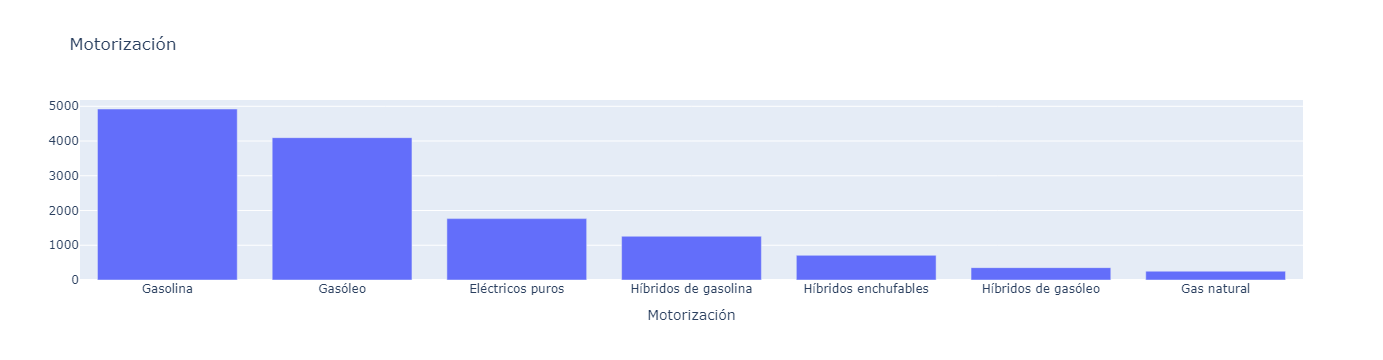

In [50]:
funcion_bar_motorizacion(df_coches)

### box[0] Electricos puros : media 16.7kwh consumo 
Estos datos indican que los coches eléctricos puros tienen un consumo de energía relativamente bajo, en comparación con los coches de gasolina o diésel. Esto se debe a que los motores eléctricos son mucho más eficientes que los motores de combustión interna.

### box[1] Gasolina :  max media 6.6litros y min media de 6.1
Estos datos indican que los coches de gasolina tienen un consumo relativamente elevado, en comparación con otros tipos de vehículos, como los coches eléctricos o los híbridos. Esto se debe a que los motores de gasolina son menos eficientes que otros tipos de motores, como los motores eléctricos o los motores híbridos.

El consumo de gasolina de un coche puede variar en función de una serie de factores, como el tamaño del vehículo, la aerodinámica, el tipo de transmisión y el estilo de conducción. En general, los coches más grandes y con aerodinámica más desfavorable suelen consumir más gasolina.



### box[2] Gasóleo :  max media 6 litros y min media de 5.4
El consumo medio de los coches de gasóleo esta entre 5.4 y 6 l/100 km.
La mayoría de los coches de gasóleo consumen entre 5 y 9 l/100 km.
Hay un pequeño número de coches de gasóleo que consumen más de 9 l/100 km.
datos indican que los coches de gasóleo tienen un consumo relativamente bajo


### box[3] Híbridos enchufables :  max media 1.5 litros y min media de 1.3
El consumo medio de los coches híbridos enchufables es de 1.4 l/100 km.
La mayoría de los coches híbridos enchufables consumen entre 2 l/100 km.
Hay un pequeño número de coches híbridos enchufables que consumen más de 10 l/100 km.
Estos datos indican que los coches híbridos enchufables tienen un consumo relativamente bajo, en comparación con los coches de gasolina o los coches diésel. Esto se debe a que los motores de combustión de los coches híbridos enchufables solo se utilizan cuando el motor eléctrico no tiene suficiente autonomía para cubrir el trayecto.


### box[4] Híbridos enchufables elec: media 16.1 :  
El consumo medio de los coches híbridos enchufables en la parte eléctrica es de 16.1 kWh/100 km.
La mayoría de los coches híbridos enchufables consumen entre 10 y 20 kWh/100 km.
Hay un pequeño número de coches híbridos enchufables que consumen más de 100 kWh/100 km.

Los datos de la gráfica también indican que hay un pequeño número de coches híbridos enchufables que tienen un consumo muy elevado. Estos coches suelen ser modelos de gama alta con baterías de gran capacidad, diseñados para ofrecer una autonomía eléctrica muy elevada.

### box[5] Híbridos gasolina:  max media 6 min media 5.6 :  
El consumo medio de los coches híbridos enchufables en la parte eléctrica es de 5.8 kWh/100 km.

La mayoría de los coches híbridos de gasolina consumen entre 4 y 8 l/100 km.

Hay un pequeño número de coches híbridos de gasolina que consumen más de 8 l/100 km.

Estos datos indican que los coches híbridos de gasolina tienen un consumo relativamente bajo, en comparación con los coches de gasolina convencionales. Esto se debe a que los motores de combustión de los coches híbridos de gasolina solo se utilizan cuando el motor eléctrico no tiene suficiente autonomía para cubrir el trayecto.


### box[6] Híbridos gasolina elec: 24.3 :  

El consumo medio de los coches híbridos de gasolina en la parte eléctrica es de 24.3 kWh/100 km.
La mayoría de los coches híbridos de gasolina consumen entre 12 y 20 kWh/100 km.
Hay un pequeño número de coches híbridos de gasolina que consumen más de 20 kWh/100 km.
El consumo medio de los coches eléctricos puros es de 11 kWh/100 km. Esto significa que los coches híbridos de gasolina consumen un 50% más que los coches eléctricos puros.

### box[7] Gas natural: max media 4.5 min media 4 :  

El consumo medio de los coches de gas natural es de 4,25 kg/100 km.
La mayoría de los coches de gas natural consumen entre 3 y 6 kg/100 km.
Hay un pequeño número de coches de gas natural que consumen más de 6 kg/100 km.


### box[8] Híbridos de gasóleo : max media 5.7 min media 5.4 :  

El consumo medio de los coches íbridos de gasóleo es de 5.6 l/100 km.
La mayoría de los coches íbridos de gasóleo consumen entre 4 y 6 l/100 km.
Hay un pequeño número de coches gasóleo consumen que consumen más de 6 l/100 km.


### DATOS GENERALES
Los coches eléctricos puros son los que tienen un consumo más eficiente, tanto en términos de consumo de energía como de consumo equivalente en gasolina.

Los coches híbridos de gasolina tienen un consumo más eficiente que los coches de gasolina convencionales, pero menos eficiente que los coches eléctricos puros.

Los coches híbridos de diésel tienen un consumo más eficiente que los coches diésel convencionales, pero similar al de los coches híbridos de gasolina.

Los coches de gas natural tienen un consumo más eficiente que los coches de gasolina o los coches diésel.


In [250]:
def funcion_boxplot_motorizacion(df_coches):
    
    df_coches.loc[df_coches['Motorización'] == 'Eléctricos puros', ['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)']] = 0
    df_coches = df_coches.dropna(subset=['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)'], how='all')
    lista_fig = []
    for tipo_motor in df_coches["Motorización"].unique():

        if tipo_motor == "Eléctricos puros":
            datos_motorizacion = df_coches[df_coches["Motorización"] == tipo_motor]["Consumo Eléctrico (kWh/100km)"]
            fig = px.box(datos_motorizacion, x=datos_motorizacion, 
                               labels={'count': 'Frecuencia', 'x': 'Consumo Eléctrico (kWh/100km)'},
                               title=f'Boxplot del Consumo - {tipo_motor}')
            lista_fig.append(fig)


        elif tipo_motor in ["Híbridos de gasolina", "Híbridos enchufables", "Híbridos de gasóleo"]:


            datos_motorizacion = df_coches[df_coches["Motorización"] == tipo_motor]["Consumo Mínimo (l/100km)"]

            fig = px.box(datos_motorizacion, x=datos_motorizacion, 
                               labels={'count': 'Frecuencia', 'x': 'Consumo Mínimo (l/100km)'},
                               title=f'Boxplot del Consumo  - {tipo_motor}')


            datos_motorizacion_2 = df_coches[df_coches["Motorización"] == tipo_motor]["Consumo Máximo (l/100km)"]

            fig.add_trace(px.box(datos_motorizacion_2, x=datos_motorizacion_2, color_discrete_sequence=['red'],
                                        labels={'count': 'Frecuencia', 'x': 'Consumo Max (l/100km)'},
                                        title=f'Boxplot del Consumo  - {tipo_motor}').data[0])
            lista_fig.append(fig)
  


            if tipo_motor != "Híbridos de gasóleo":

                datos_motorizacion = df_coches[df_coches["Motorización"] == tipo_motor]["Consumo Eléctrico (kWh/100km)"]

                fig = px.box(datos_motorizacion, x=datos_motorizacion, 
                               labels={'count': 'Frecuencia', 'x': 'Consumo Eléctrico (kWh/100km)'},
                               title=f'Boxplot del Consumo Eléctrico - {tipo_motor}')
                lista_fig.append(fig)


            else:
                pass

        else:

            datos_motorizacion = df_coches[df_coches["Motorización"] == tipo_motor]["Consumo Mínimo (l/100km)"]

            fig = px.box(datos_motorizacion, x=datos_motorizacion,
                               labels={'count': 'Frecuencia', 'x': 'Consumo Mínimo (l/100km)'},
                               title=f'Boxplot del Consumo {tipo_motor}')


            datos_motorizacion_2 = df_coches[df_coches["Motorización"] == tipo_motor]["Consumo Máximo (l/100km)"]
            
            fig.add_trace(px.box(datos_motorizacion_2, x=datos_motorizacion_2, color_discrete_sequence=['red'],
                                        labels={'count': 'Frecuencia', 'x': 'Consumo Max (l/100km)'},
                                        title=f'Boxplot del Consumo  - {tipo_motor}').data[0],
                                        )
            
            
            lista_fig.append(fig)

    return lista_fig

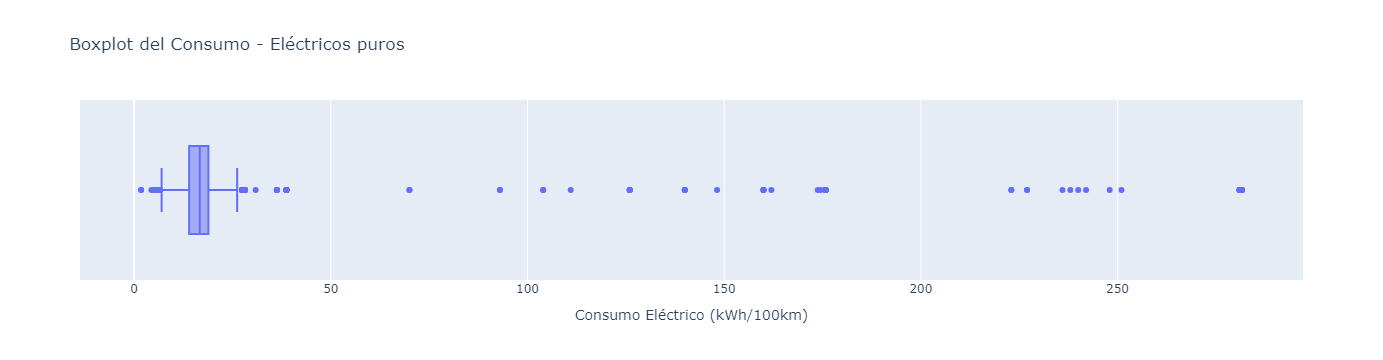

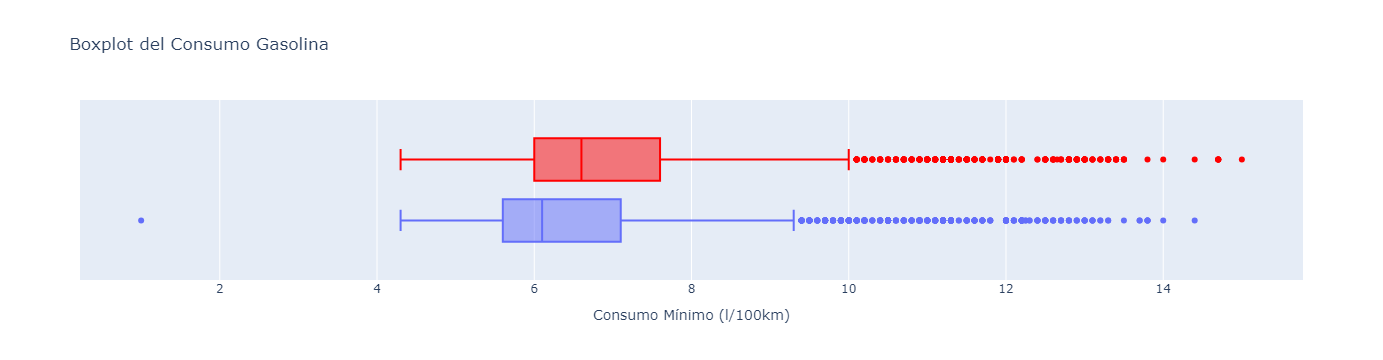

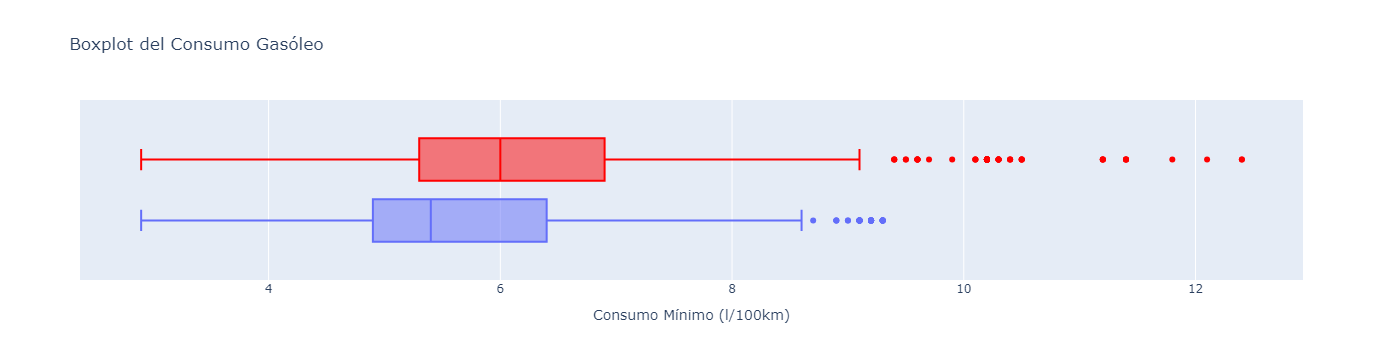

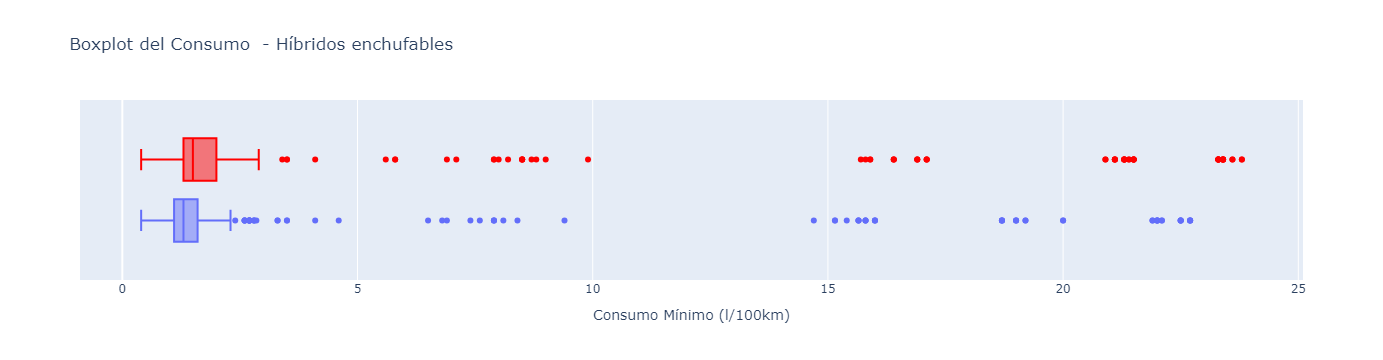

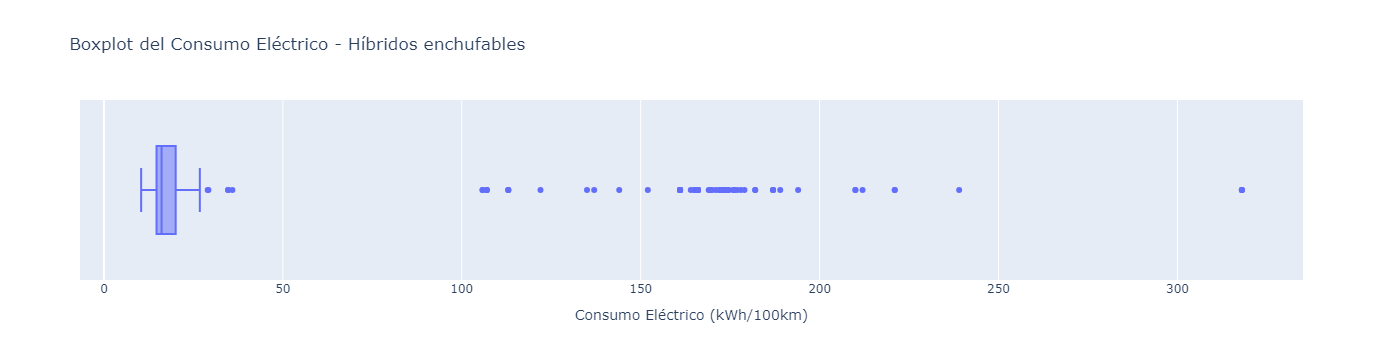

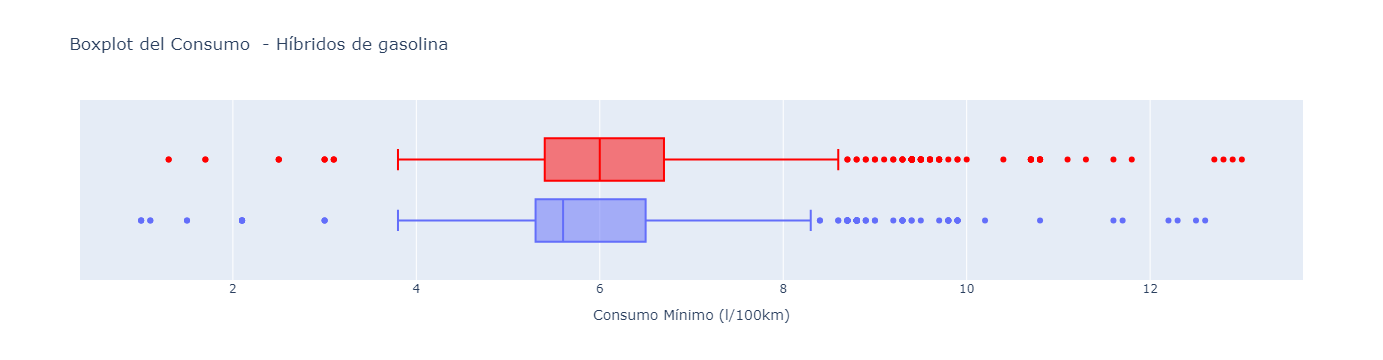

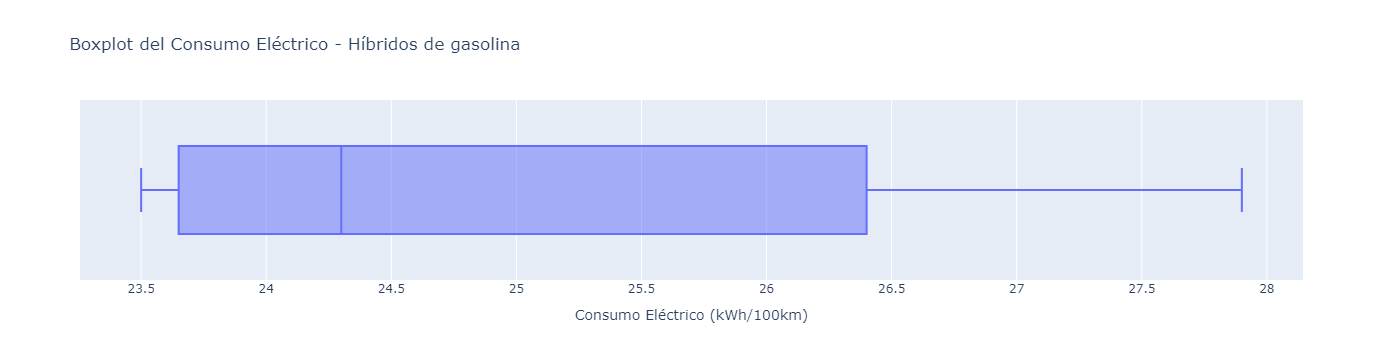

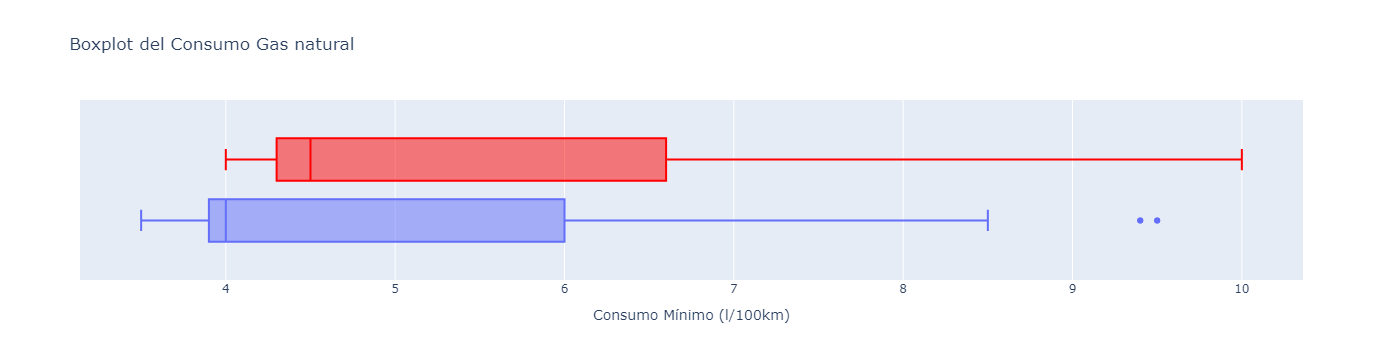

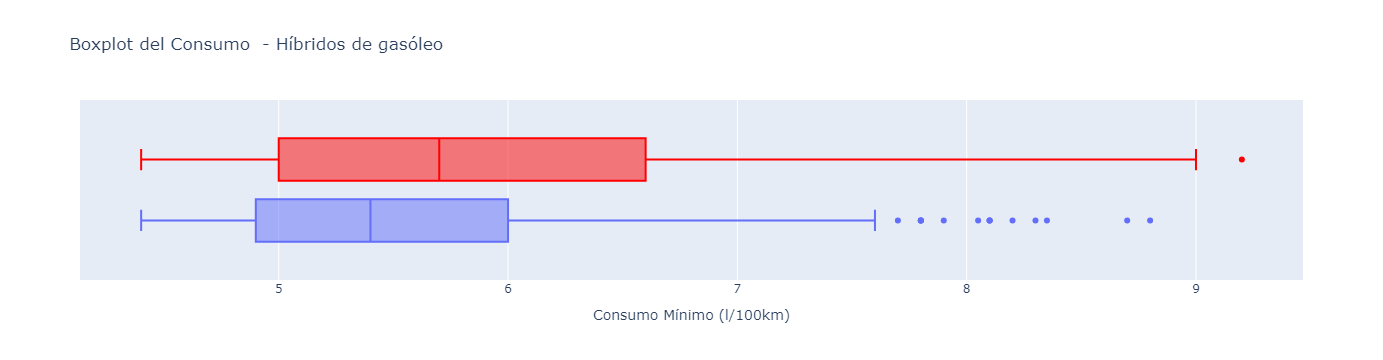

In [253]:
box = funcion_boxplot_motorizacion(df_coches)
for figura in box:
    figura.show()

In [62]:
def funcion_boxplot_motorizacion_usuario(tipo_motor):
    box = funcion_boxplot_motorizacion(df_coches)
    if tipo_motor == "Eléctricos puros":
        return box[0].show()
    elif tipo_motor == "Gasolina":
        return box[1].show()
    elif tipo_motor == "Gasóleo":
        return box[2].show()
    elif tipo_motor == "Híbridos enchufable":
        return box[3].show(),box[4].show()
    elif tipo_motor == "Híbridos gasolina":
         (box[5].show(),box[6].show())
    elif tipo_motor == "Gas natural":
        return box[7].show()
    elif tipo_motor == "Híbridos de gasóleo":
        return box[8].show()

### Híbridos gasolina

### Híbridos gasolina:  max media 6 min media 5.6 :  
El consumo medio de los coches híbridos enchufables en la parte eléctrica es de 5.8 kWh/100 km.

La mayoría de los coches híbridos de gasolina consumen entre 4 y 8 l/100 km.

Hay un pequeño número de coches híbridos de gasolina que consumen más de 8 l/100 km.

Estos datos indican que los coches híbridos de gasolina tienen un consumo relativamente bajo, en comparación con los coches de gasolina convencionales. Esto se debe a que los motores de combustión de los coches híbridos de gasolina solo se utilizan cuando el motor eléctrico no tiene suficiente autonomía para cubrir el trayecto.


### Híbridos gasolina elec: 24.3 :  

El consumo medio de los coches híbridos de gasolina en la parte eléctrica es de 24.3 kWh/100 km.
La mayoría de los coches híbridos de gasolina consumen entre 12 y 20 kWh/100 km.
Hay un pequeño número de coches híbridos de gasolina que consumen más de 20 kWh/100 km.
El consumo medio de los coches eléctricos puros es de 11 kWh/100 km. Esto significa que los coches híbridos de gasolina consumen un 50% más que los coches eléctricos puros.

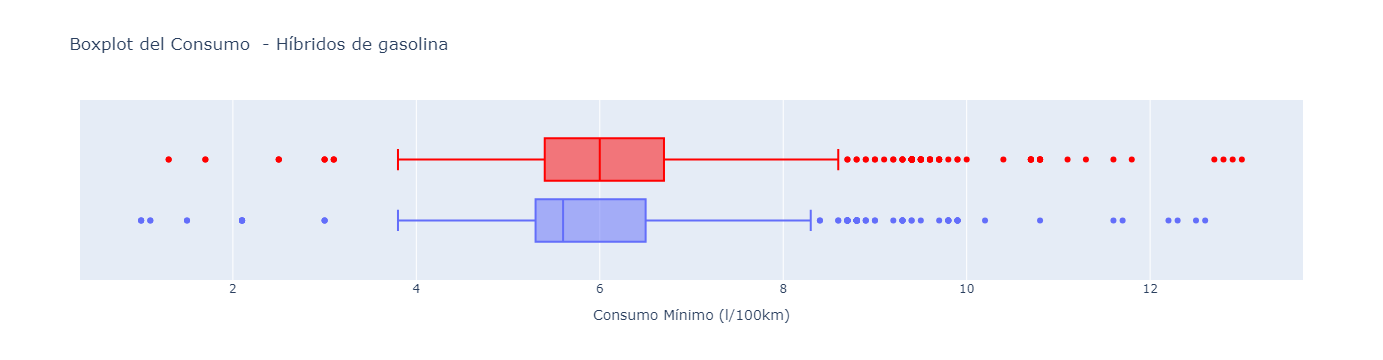

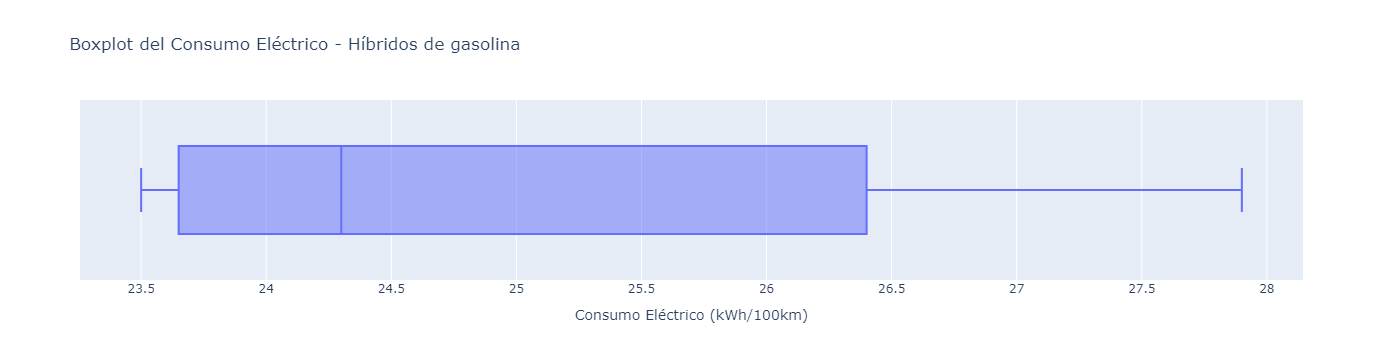

In [63]:
funcion_boxplot_motorizacion_usuario("Híbridos gasolina")

### Gas natural: max media 4.5 min media 4 :  

El consumo medio de los coches de gas natural es de 4,25 kg/100 km.
La mayoría de los coches de gas natural consumen entre 3 y 6 kg/100 km.
Hay un pequeño número de coches de gas natural que consumen más de 6 kg/100 km.

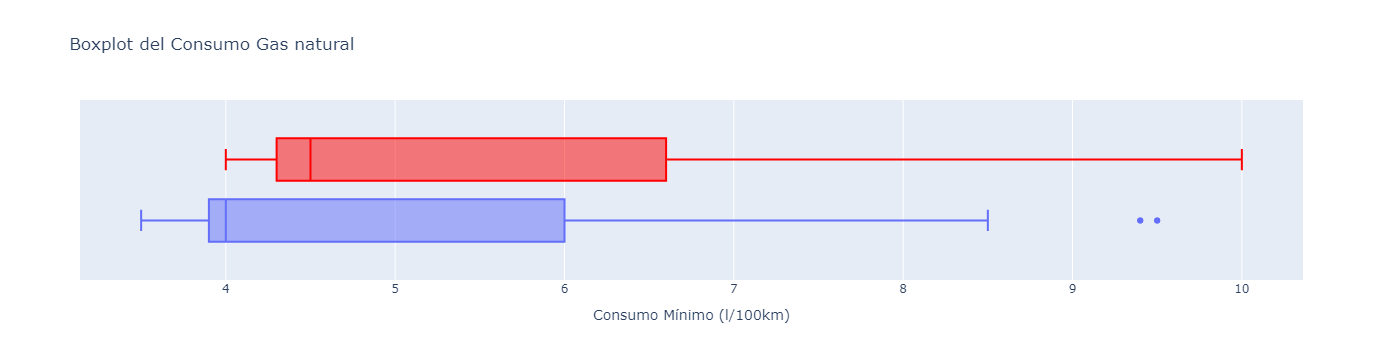

In [61]:
funcion_boxplot_motorizacion_usuario("Gas natural")


### Híbridos de gasóleo : max media 5.7 min media 5.4 :  

El consumo medio de los coches íbridos de gasóleo es de 5.6 l/100 km.
La mayoría de los coches íbridos de gasóleo consumen entre 4 y 6 l/100 km.
Hay un pequeño número de coches gasóleo consumen que consumen más de 6 l/100 km.

### FOLIUM

In [146]:
df_cargadores = pd.read_csv("Data/df_cargadores.csv")

In [147]:
df_cargadores = df_cargadores[~((df_cargadores["latitude"] == 40.579369) & (df_cargadores["longitude"] == 17.036496))]
df_cargadores = df_cargadores[~((df_cargadores["latitude"] == 42.208634) & (df_cargadores["longitude"] == 24.043651))]
df_cargadores = df_cargadores[~((df_cargadores["latitude"] == 37.41559459787993) & (df_cargadores["longitude"] == -122.07737083821156))]
df_cargadores["cargadores"] = df_cargadores["cargadores"].apply(lambda x: ast.literal_eval(x.replace("nan", "False")))
df_cargadores.reset_index(drop=True, inplace=True)

In [148]:
title2 = []
formalname2 = []
energia2 = []
carga_rapida2 = []
for punto, i in zip(df_cargadores['cargadores'], range(len(df_cargadores))):
    title = []
    formalname = []
    energia = []
    carga_rapida = []
    for cargador in punto:
        title.append(cargador['title'])
        formalname.append(cargador['formalName'])
        energia.append(cargador['energia'])
        if cargador['isFastChargeCapable'] == True:
            carga_rapida.append("Sí")
        elif cargador['isFastChargeCapable'] == False:
            carga_rapida.append("No")
        
    title2.append(title)
    formalname2.append(formalname)
    energia2.append(energia)
    carga_rapida2.append(carga_rapida)


In [149]:
df_cargadores["title"] = title2
df_cargadores["energia"] = formalname2
df_cargadores["formalName"] = energia2
df_cargadores["isfastChargeCapable"] = carga_rapida2
df_cargadores = df_cargadores.fillna("Desconocido")

In [150]:
def funcion_folium_cp_radio(cp,radio):
# Define el nombre de tu aplicación o proyecto
    nombre_app = "Mi Aplicación de Geolocalización"
    
    # Crea una instancia del geolocalizador y proporciona el nombre de tu aplicación como user_agent
    geolocator = Nominatim(user_agent=nombre_app)
    
    direccion = f"{str(cp)}, España"
    # Obtener las coordenadas de la dirección
    location = geolocator.geocode(direccion)
    
    # Imprimir las coordenadas
    if location:
        localizacion_inicial = [location.latitude, location.longitude]

    else:
        print("La dirección no se encontró.")

    # Crear un mapa centrado en las coordenadas iniciales
    mapa = folium.Map(location=localizacion_inicial, zoom_start=13)

    # Iterar sobre las filas del DataFrame y agregar marcadores al mapa
    for index, row in df_cargadores.iterrows():
        coordenadas_punto = (row['latitude'], row['longitude'])
        distancia = geodesic(localizacion_inicial, coordenadas_punto).kilometers

        tiene_carga_rapida = False
        for valor in row['isfastChargeCapable']:
            if valor == "Sí": 
                tiene_carga_rapida = True
                break  
        html_popup = f'''
                <div style="min-width: 600px; max-width: 600px; font-size: 16px;">
                    <p><strong>Dirección:</strong> {str(row["addressLine1"])}</p>
                    <p><strong>Tipo de cargadores:</strong> {str(row["title"]).replace("[", "").replace("]", "").replace("'", "")}</p>
                    <p><strong>Energía de cada cargador:</strong> {str(row["energia"]).replace("[", "").replace("]", "").replace("'", "")}</p>
                    <p><strong>¿Tiene carga rápida?:</strong> {str(row["isfastChargeCapable"]).replace("[", "").replace("]", "").replace("'", "")}</p>
                    <p><strong>Distancia a tu ubicación:</strong> {distancia:.2f} km</p>
                </div>
            '''
        if tiene_carga_rapida == True:
        # Agregar marcador solo si la distancia es menor o igual a 1 km
            if distancia <= radio:

                folium.Marker(location=coordenadas_punto, popup=folium.Popup(html=html_popup),  icon=folium.Icon(icon='flash')).add_to(mapa)
                
        else:        
            if distancia <= radio:
                folium.Marker(location=coordenadas_punto, popup=folium.Popup(html=html_popup)).add_to(mapa)

    return mapa


### PPRECIO ELECTRCIDAD CARGADOR MEDIO

### media de los precios de cargadores electricos

In [274]:
# Expresión regular para encontrar el precio
patron_precio = r"(\d+,\d+)€"
lista_precio = []
# Iterar sobre cada fila y extraer el precio si está presente
for fila in df_cargadores["usageCost"]:
    try:
        fila = fila.split(" ")
        for num in fila:
            match = re.search(patron_precio, num)
            if match:
                precio = match.group(1)
                lista_precio.append((float(precio.replace(",","."))))
            else:
                pass
    except:
        pass
    

In [275]:
media = sum(lista_precio)/len(lista_precio)

In [276]:
media

0.39528688566335274

### FUNCIONES PRECIO BATERIA

In [277]:
df_coches = pd.read_csv("Data/df_coches_escrapeo.csv")
df_coches = df_coches[(df_coches["MTMA (Kg)"] > 400) & (df_coches["MTMA (Kg)"] < 3000)]
df_coches = df_coches[df_coches["Motorización"].notnull()]
df_coches.reset_index(inplace =True, drop=True)

In [278]:
df_coches[df_coches["Motorización"]=="Eléctricos puros"]

,Modelo,Consumo Mínimo (l/100km),Consumo Máximo (l/100km),Emisiones Mínimo,Emisiones Máximo,MTMA (Kg),Motorización,Consumo Eléctrico (kWh/100km),Potencia eléctrica (kW),Autonomía eléctrica (km),...,N2,N3,A,B,C,D,E,F,G,Sin clasificacion
0,AIWAYS U5 MAS861-WVTA/2WB/FL4,NaN,NaN,NaN,NaN,2135.0,Eléctricos puros,15.8,55.0,400.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,AIWAYS U6 PRIME,NaN,NaN,NaN,NaN,2290.0,Eléctricos puros,16.0,160.0,405.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,ALKE ATX 310 E plomo acido,NaN,NaN,NaN,NaN,1510.0,Eléctricos puros,11.0,14.0,75.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,ALKE ATX 320 E plomo acido,NaN,NaN,NaN,NaN,1510.0,Eléctricos puros,11.0,14.0,75.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ALKE ATX 330 E plomo acido,NaN,NaN,NaN,NaN,1510.0,Eléctricos puros,11.0,14.0,75.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376,ZERO MOTORCYCLES FXE,NaN,NaN,NaN,NaN,454.0,Eléctricos puros,8.4,15.0,106.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13377,ZERO MOTORCYCLES SR,NaN,NaN,NaN,NaN,454.0,Eléctricos puros,11.5,40.0,152.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13378,ZERO MOTORCYCLES SR/F,NaN,NaN,NaN,NaN,454.0,Eléctricos puros,11.5,40.0,163.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13379,ZERO MOTORCYCLES SR/S Premium,NaN,NaN,NaN,NaN,454.0,Eléctricos puros,11.5,40.0,163.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [279]:
def funcion_precio_bateriacompleta_modelo_e(modelo):
    precio_kwh = 0.39528688566335274
    datos_coche=df_coches[df_coches["Modelo"] == modelo]
    consumo_kwh_100km = datos_coche["Consumo Eléctrico (kWh/100km)"].reset_index(drop=True)[0]
    Autonomia = datos_coche["Autonomía eléctrica (km)"].reset_index(drop=True)[0]
    precio_bateria = ((consumo_kwh_100km*Autonomia)/100)*precio_kwh
    return(precio_bateria)

In [280]:
funcion_precio_modelo_e("AIWAYS U5 MAS861-WVTA/2WB/FL4")

24.982131173923893

### Funcion precio km electrico

In [284]:
def funcion_precio_km_e(modelo):
    precio_kwh = 0.39528688566335274
    datos_coche=df_coches[df_coches["Modelo"] == modelo]
    consumo_kwh_100km = datos_coche["Consumo Eléctrico (kWh/100km)"].reset_index(drop=True)[0]
    precio_km = (consumo_kwh_100km/100)*precio_kwh
    return(precio_km)

In [285]:
funcion_precio_km_e("ZERO MOTORCYCLES SR/S Standard")

0.045457991851285566

### SERIE TEMPORAL

In [299]:
df = pd.read_csv("../../3PROYECTO/Precios_Gasolina_y_Precios_Gasoleo.csv")

In [300]:
df

,Año,Semana,Precio Gasolina,Precio Gasoleo
0,2002,Semana 1,0.759,0.673
1,2002,Semana 2,0.759,0.673
2,2002,Semana 3,0.767,0.673
3,2002,Semana 4,0.762,0.667
4,2002,Semana 5,0.762,0.668
...,...,...,...,...
1135,2023,Semana 52,1.531,1.492
1136,2024,Semana 1,1.534,1.493
1137,2024,Semana 2,1.535,1.488
1138,2024,Semana 3,1.535,1.483


In [16]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout, LSTM
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [19]:
def sacar_x_y(lista, T):
    T = T # Segmentos
    X = list()
    Y = list()

    for t in range(len(lista) - T):

        x = lista[t : t + T]
        X.append(x)


        y = lista[t + T]
        Y.append(y)

    # Transformamos a np.array y ajustamos las dimensiones
    # Para entrar en el modelo debe de tener 3 dimensiones
    X = np.array(X).reshape(-1, T, 1)
    Y = np.array(Y)
    N = len(X)

    return X, Y, T

In [44]:

# Modelo Simple 2 MODELO GANADOR
modelo_2 = Sequential()

modelo_2.add(Input(shape = (T, 1)))

modelo_2.add(SimpleRNN(units = 512, activation = "relu"))


modelo_2.add(Dense(units = 256, activation = "relu"))
modelo_2.add(Dense(units = 128, activation = "relu")) 
modelo_2.add(Dense(units = 64, activation = "relu")) 
modelo_2.add(Dense(units = 32, activation = "relu")) 
modelo_2.add(Dense(units = 1))

modelo_2.compile(optimizer = "adam", loss = "mse")

#modelo_2.summary()

X_train_2, y_train_2, T = sacar_x_y(df["Precio Gasoleo"].to_list(), 10)

history = modelo_2.fit(x = X_train_2,
                    y = y_train_2,
                    epochs = 200)

print("------------------------------------------")

instancia = df["Precio Gasoleo"][-11: -1].to_list()
instancia = np.array(instancia).reshape(-1, T, 1)

prediccion_primera_semana_febrero = modelo_2.predict(instancia)
prediccion_primera_semana_febrero = prediccion_primera_semana_febrero[0][0]
prediccion_primera_semana_febrero

Epoch 1/200
36/36 [==============================] - 1s 7ms/step - loss: 0.1015
Epoch 2/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 3/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 4/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 5/200
36/36 [==============================] - 0s 7ms/step - loss: 9.3488e-04
Epoch 6/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 7/200
36/36 [==============================] - 0s 7ms/step - loss: 9.0149e-04
Epoch 8/200
36/36 [==============================] - 0s 7ms/step - loss: 9.9230e-04
Epoch 9/200
36/36 [==============================] - 0s 7ms/step - loss: 9.3777e-04
Epoch 10/200
36/36 [==============================] - 0s 7ms/step - loss: 7.9319e-04
Epoch 11/200
36/36 [==============================] - 0s 7ms/step - loss: 9.2162e-04
Epoch 12/200
36/36 [==============================] - 0s 7ms/step - loss: 9.0439e-04
Epoch 13/

1.4850451

In [45]:
instancia = df["Precio Gasoleo"][-10: -1].to_list()
input_usuario = 1.49
instancia.append(input_usuario)
instancia = np.array(instancia).reshape(-1, T, 1)

prediccion_semana_5 = modelo_2.predict(instancia)
prediccion_semana_5 = prediccion_semana_5[0][0]
prediccion_semana_5

1/1 [==============================] - 0s 42ms/step


1.5005934

In [46]:
with open('model_gasoleo_pkl.pkl', 'wb') as f:
    pickle.dump(modelo_2, f)

In [47]:
with open('Data/model_gasoleo_pkl.pkl', 'rb') as file:
    modelo_pkl = pickle.load(file)

### FUNCION PREDICCION GASOLINA

In [294]:
def predicion_gasolina():
    df = pd.read_csv("../../3PROYECTO/Precios_Gasolina_y_Precios_Gasoleo.csv")
    precio_gasolina = float(input("Ingrese el precio de la gasolina esta semana:"))
    instancia = df["Precio Gasolina"][-10: -1].to_list()
    instancia.append(precio_gasolina)
    instancia = np.array(instancia).reshape(-1, 10, 1)
    
    with open('Data/model_gasolina_pkl.pkl', 'rb') as file:
        modelo_pkl = pickle.load(file)
    
    prediccion_precio = modelo_pkl.predict(instancia)
    prediccion_precio = prediccion_precio[0][0]
    return(prediccion_precio)

In [296]:
predicion_gasolina()

Ingrese el precio de la gasolina esta semana: 1.25


1/1 [==============================] - 0s 137ms/step


1.0107133

### FUNCION PREDICCION GASOLEO

In [316]:
### TIENE EL DF DENTRO CORREGIR RUTA, (TENER EN CUENTA QUE PIDE EL TIPO DE COMBUSTIBLE PARA MOSTRAR GRAFICA)

In [309]:
def funcion_line_precio(combustible):
    df = pd.read_csv("../../3PROYECTO/Precios_Gasolina_y_Precios_Gasoleo.csv")
    df["Semana"] = df["Semana"].apply(lambda x: x.split(" ")[1])
    df['Fecha'] = df.apply(lambda row: pd.to_datetime(f'{int(row["Año"])}-W{int(row["Semana"])}-1', format='%G-W%V-%u'), axis=1)
    fig = px.line(data_frame = df, x = "Fecha", y = f"Precio {combustible.capitalize()}")
    return fig

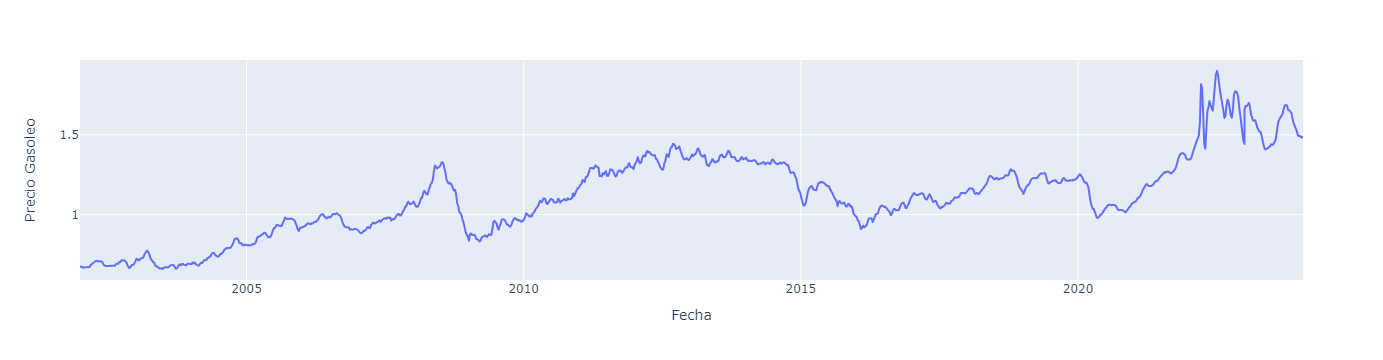

In [314]:
funcion_line_precio("gasoleo")

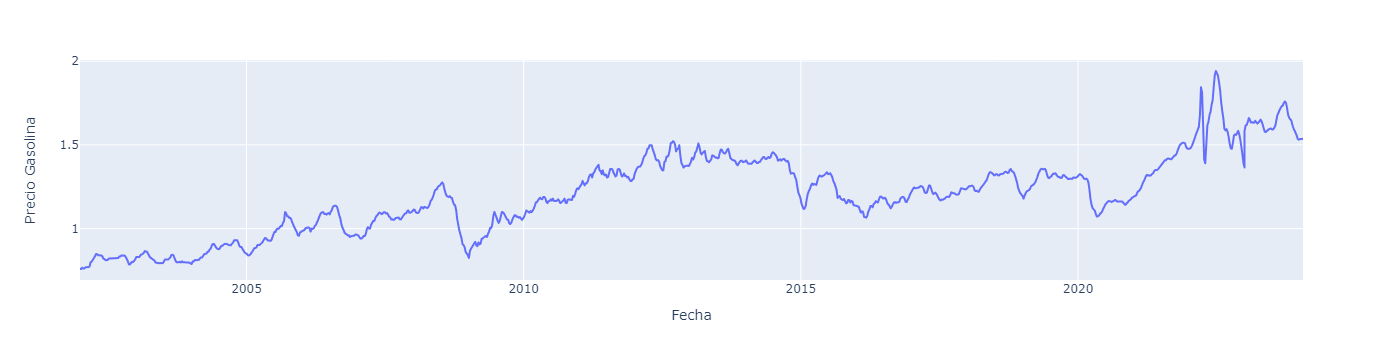

In [315]:
funcion_line_precio("Gasolina")

In [76]:
df_coches[(df_coches["Emisiones Máximo"]>0) & (df_coches["Motorización"] == "Gasolina")]

,Modelo,Consumo Mínimo (l/100km),Consumo Máximo (l/100km),Emisiones Mínimo,Emisiones Máximo,MTMA (Kg),Motorización,Consumo Eléctrico (kWh/100km),Potencia eléctrica (kW),Autonomía eléctrica (km),...,N2,N3,A,B,C,D,E,F,G,Sin clasificacion
23,Abarth 595 ABARTH 595 1.4 16v T-JET 107 KW (14...,7.2,7.4,162.0,165.0,1045.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,Abarth 595 ABARTH 595 COMPETIZIONE 1.4 16v T-J...,7.7,7.8,171.0,172.0,1065.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25,Abarth 595 ABARTH 595 ESSEESSE 1.4 16v T-JET 1...,7.7,7.8,171.0,172.0,1065.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26,Abarth 595 ABARTH 595 MONSTER ENERGY YAMAHA 1....,7.4,7.5,165.0,168.0,1065.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27,Abarth 595 ABARTH 595 PISTA 1.4 16v T-JET 121 ...,7.4,7.5,165.0,168.0,1065.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13200,"Volvo XC40 Gasolina, Essential, Core, Plus, Au...",7.2,7.9,162.0,179.0,2120.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13206,"Volvo XC40 Momentum Core, Momentum Pro, Inscri...",7.2,7.9,162.0,179.0,2120.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13207,"Volvo XC40 Momentum Core, Momentum Pro, Inscri...",6.8,7.6,154.0,173.0,2080.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13208,"Volvo XC40 Momentum Core, Momentum Pro, Inscri...",7.2,7.9,162.0,179.0,2120.0,Gasolina,NaN,NaN,NaN,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### PREGUNTA - QUE RELACION HAY ENTRE EL CONSUMO Y LAS EMISIONES?
En esta grafica vemos una evolución lineal entre el consumo y las emisiones, demostrando la gran correlación entre estas. Y que lógicamente los eléctricos puros no emiten 

In [130]:
def funcion_emisiones_consumo():
    df_filtrado = df_coches
    fig = px.scatter(data_frame =df_coches,
           x = "Consumo Máximo (l/100km)",
          y = "Emisiones Máximo",
          color = "Motorización" )
    fig.show()

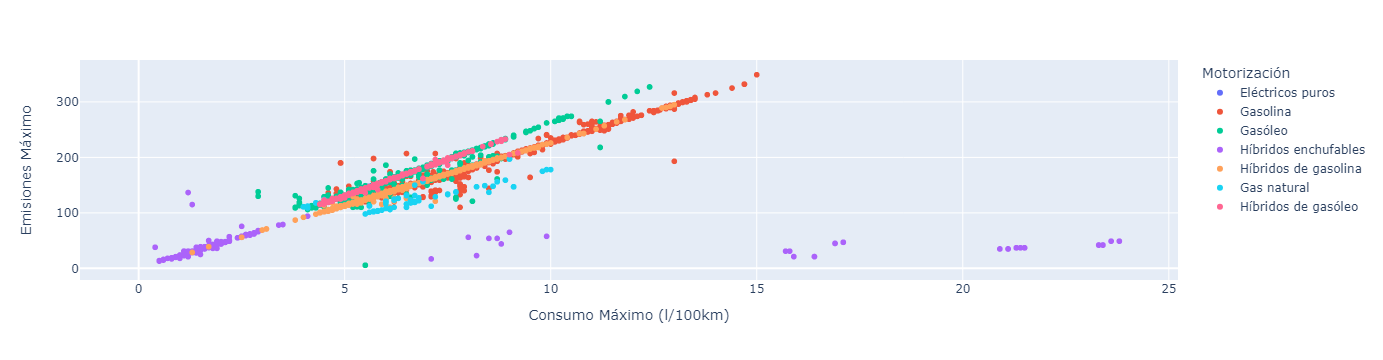

In [131]:
funcion_emisiones_consumo()

###  EMITEN MAS CO2 FRENTE A LOS HIBRIDOS
En la gráfica de quesito podemos observar que las emisiones de co2, tanto de los híbridos como los coches de combustión puro, rondan el 20% esto se debe a que ambos utilizan el mismo tipo de combustible. Lo que cambia en este caso es la frecuencia de uso. ya que los coches híbridos parte de su consumo es eléctrico.

In [132]:
def funcion_quesito_emisiones():
    df_filtrado = df_coches
    fig = px.pie(data_frame = df_filtrado,
    values=df_filtrado.groupby("Motorización").mean()["Emisiones Máximo"].to_list(),
    names = df_filtrado.groupby("Motorización").mean().index)
    fig.show()

In [133]:
df_coches.groupby("Motorización").mean()

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\1996596367.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Consumo Mínimo (l/100km),Consumo Máximo (l/100km),Emisiones Mínimo,Emisiones Máximo,MTMA (Kg),Consumo Eléctrico (kWh/100km),Potencia eléctrica (kW),Autonomía eléctrica (km),Capacidad de la batería (kWh),Consumo Mínimo (kg/100km),...,N2,N3,A,B,C,D,E,F,G,Sin clasificacion
Motorización,,,,,,,,,,,,,,,,,,,,,
Eléctricos puros,0.000000,0.000000,NaN,NaN,1995.393888,21.824187,83.017744,244.817302,38.066843,NaN,...,0.001132,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Gas natural,5.006496,5.482677,111.655118,121.857087,1799.732283,NaN,NaN,NaN,NaN,4.78615,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Gasolina,6.620046,7.077960,150.578637,160.659044,1890.974401,NaN,8.250000,NaN,79.523301,NaN,...,0.000000,0.0,0.045091,0.204383,0.375685,0.175727,0.092078,0.043826,0.064054,0.009692
Gasóleo,5.632442,6.169198,147.123114,160.556362,2205.602473,NaN,17.053571,NaN,78.876404,NaN,...,0.000000,0.0,0.021494,0.125384,0.258700,0.247697,0.124616,0.049642,0.035056,0.149949
Híbridos de gasolina,5.899881,6.287292,134.247419,142.199603,2024.546465,24.853846,23.843750,60.230769,3.740449,NaN,...,0.000000,0.0,0.294599,0.348609,0.219313,0.087561,0.040098,0.004092,0.005728,0.002455
Híbridos de gasóleo,5.607865,5.870084,146.485393,153.505056,2228.174157,NaN,7.662431,NaN,0.400000,NaN,...,0.000000,0.0,0.000000,0.192878,0.406528,0.189911,0.136499,0.068249,0.011869,0.000000
Híbridos enchufables,2.453500,2.982286,31.760873,37.508584,2312.388028,36.264264,87.998720,59.978955,17.176162,NaN,...,0.000000,0.0,0.922401,0.007321,0.004392,0.000000,0.002928,0.000000,0.068814,0.001464


In [125]:
df_coches.groupby("Motorización").mean().index

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\1074144199.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Index(['Eléctricos puros', 'Gas natural', 'Gasolina', 'Gasóleo',
       'Híbridos de gasolina', 'Híbridos de gasóleo', 'Híbridos enchufables'],
      dtype='object', name='Motorización')

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\2670417574.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\2670417574.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



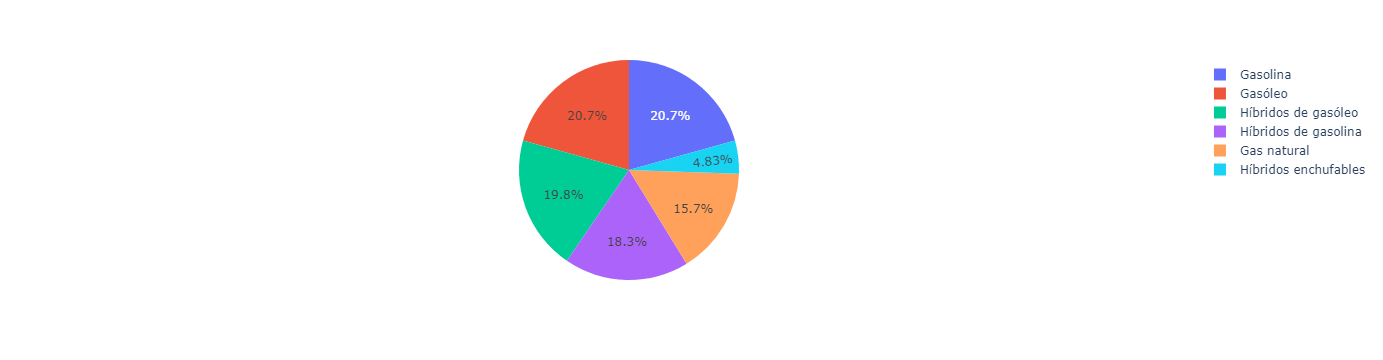

In [119]:
funcion_quesito_emisiones()

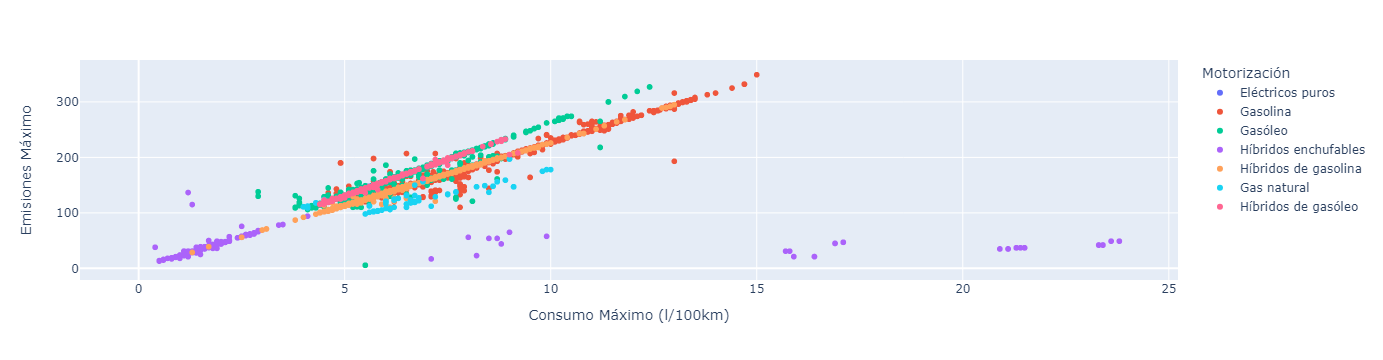

In [122]:
funcion_emisiones_consumo()

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\2093733745.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



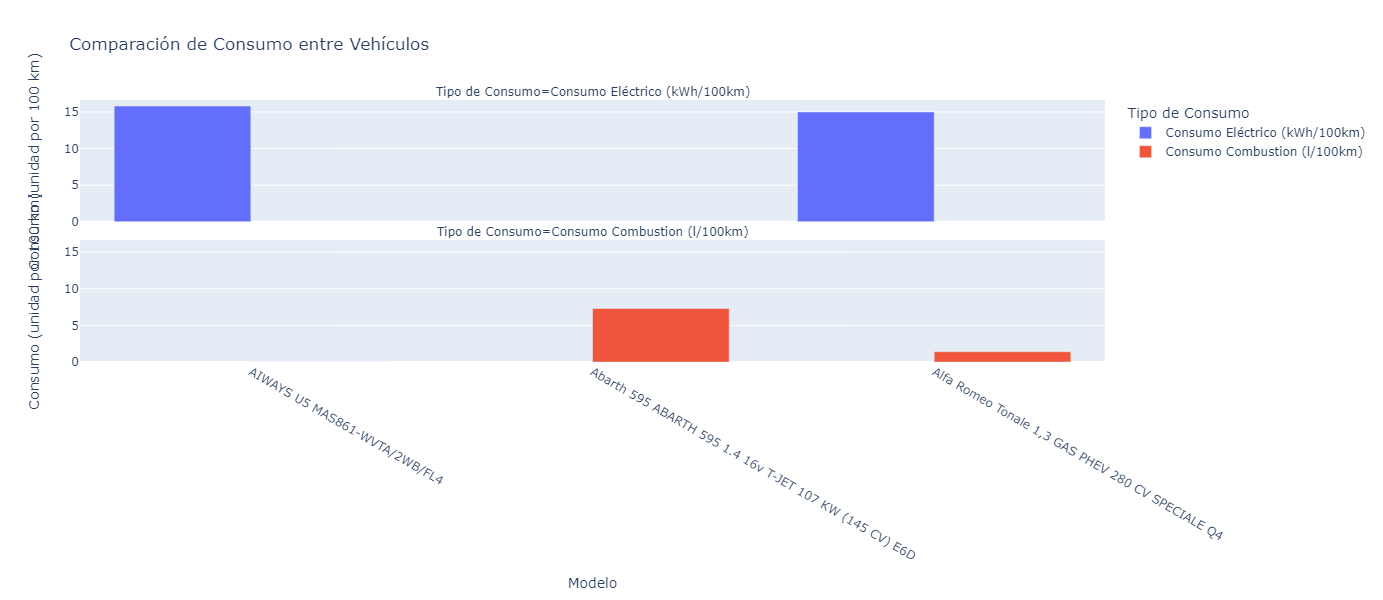

In [134]:
# Supongamos que tienes un DataFrame llamado df_coches con información similar a la proporcionada

# Filtrar los datos para los modelos específicos
modelos_seleccionados = [
    'Abarth 595 ABARTH 595 1.4 16v T-JET 107 KW (145 CV) E6D',
    'AIWAYS U5 MAS861-WVTA/2WB/FL4',
    'Alfa Romeo Tonale 1,3 GAS PHEV 280 CV SPECIALE Q4'
]

df_seleccionados = df_coches[df_coches['Modelo'].isin(modelos_seleccionados)]

# Calcular el consumo promedio para vehículos de combustión
df_seleccionados['Consumo Combustion (l/100km)'] = df_seleccionados[['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)']].mean(axis=1)

# Reorganizar el DataFrame para el gráfico
df_melted = pd.melt(df_seleccionados, id_vars='Modelo', value_vars=['Consumo Eléctrico (kWh/100km)', 'Consumo Combustion (l/100km)'], var_name='Tipo', value_name='Consumo')

# Crear el gráfico de barras con Plotly Express
fig = px.bar(df_melted, x='Modelo', y='Consumo', color='Tipo',
             labels={'Consumo': 'Consumo (unidad por 100 km)', 'Tipo': 'Tipo de Consumo'},
             title='Comparación de Consumo entre Vehículos',
             facet_col='Tipo', facet_col_wrap=1,
             barmode='group')

# Ajustar diseño para mejorar la visualización
fig.update_layout(height=600, width=800)

# Mostrar el gráfico
fig.show()

In [136]:
#EN combustion entran los de gasolina gasoleo gas natural e gases licuados del petroleo
seleccionCombustion = 'Abarth 595 ABARTH 595 1.4 16v T-JET 107 KW (145 CV) E6D'
#En electricos entran los electricos puros
seleccionElectrico =  'AIWAYS U5 MAS861-WVTA/2WB/FL4'
#En los hibridos entran hibridos de gasoleo y de gasolina
seleccionHibrido =  'Alfa Romeo Tonale 1,3 GAS PHEV 280 CV SPECIALE Q4'

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\1725534519.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



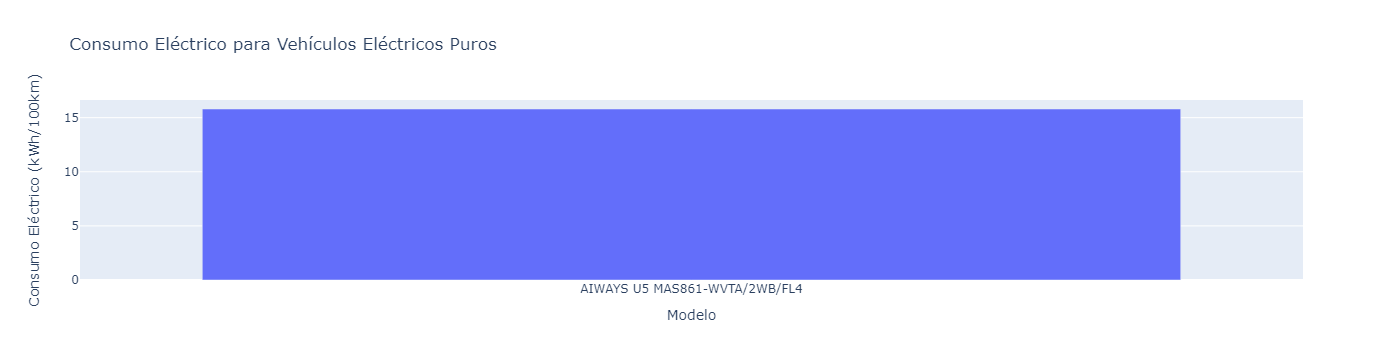

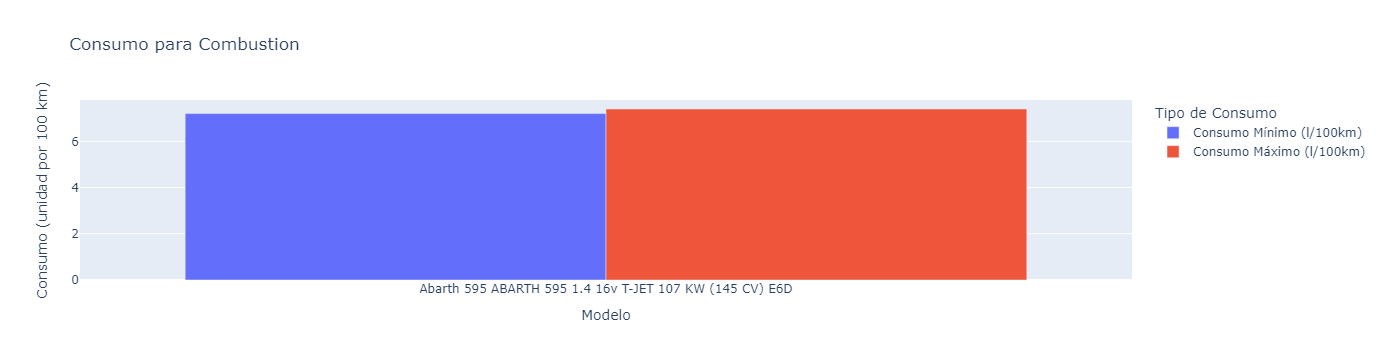

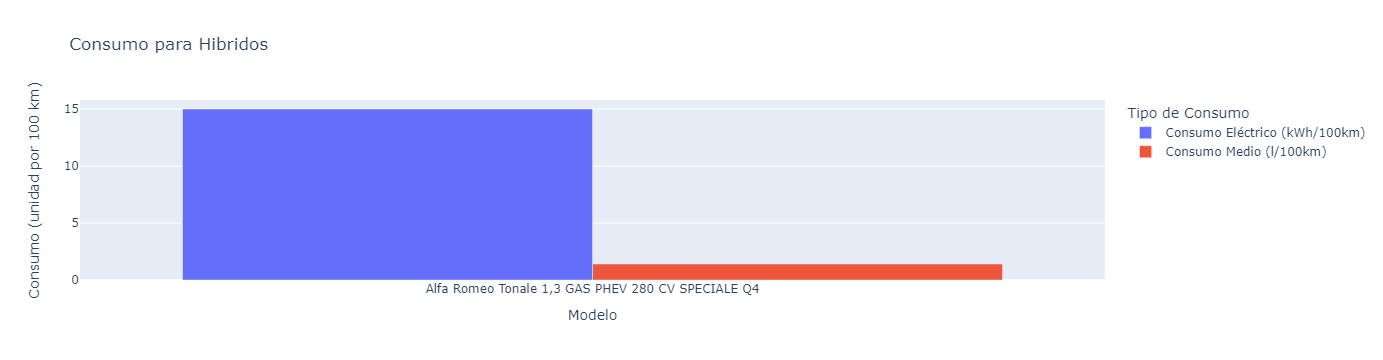

In [226]:
# Crear el DataFrame para cada tipo de vehículo
df_electrico = df_coches[df_coches['Modelo'] == seleccionElectrico]
df_combustion = df_coches[df_coches['Modelo'] == seleccionCombustion]
df_hibrido = df_coches[df_coches['Modelo'] == seleccionHibrido]


# Calcular el consumo medio para el híbrido (promedio entre Consumo Mínimo y Máximo)
df_hibrido['Consumo Medio (l/100km)'] = (df_hibrido['Consumo Mínimo (l/100km)'] + df_hibrido['Consumo Máximo (l/100km)']) / 2

# Crear el gráfico para vehículos eléctricos
fig_electrico = px.bar(df_electrico, x='Modelo', y='Consumo Eléctrico (kWh/100km)',
                       title='Consumo Eléctrico para Vehículos Eléctricos Puros')

# Crear el gráfico para vehículos de combustión
fig_combustion = px.bar(df_combustion, x='Modelo', y=['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)'],
                        labels={'value': 'Consumo (unidad por 100 km)', 'variable': 'Tipo de Consumo'},
                        title=f'Consumo para Combustion', barmode='group')

# Crear el gráfico para vehículos híbridos
fig_hibrido = px.bar(df_hibrido, x='Modelo', y=['Consumo Eléctrico (kWh/100km)', 'Consumo Medio (l/100km)'],
                     labels={'value': 'Consumo (unidad por 100 km)', 'variable': 'Tipo de Consumo'},
                     title=f'Consumo para Hibridos', barmode='group')

# Mostrar los gráficos
fig_electrico.show()
fig_combustion.show()

fig_hibrido.show()


In [146]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [238]:
df_hibrido = df_coches[df_coches['Modelo'] == seleccionHibrido]
df_hibrido

,Modelo,Consumo Mínimo (l/100km),Consumo Máximo (l/100km),Emisiones Mínimo,Emisiones Máximo,MTMA (Kg),Motorización,Consumo Eléctrico (kWh/100km),Potencia eléctrica (kW),Autonomía eléctrica (km),...,N3,A,B,C,D,E,F,G,Sin clasificacion,Consumo medio l/1km
93,"Alfa Romeo Tonale 1,3 GAS PHEV 280 CV SPECIALE Q4",1.3,1.5,26.0,38.0,2470.0,Híbridos enchufables,15.0,90.0,69.0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014


In [221]:
df_coches["Consumo medio l/1km"] = df_coches[["Consumo Máximo (l/100km)", "Consumo Mínimo (l/100km)"]].mean(axis=1)/100


In [246]:
def funcion_comparacion_seleccion_usario_modelo(seleccionElectrico,seleccionCombustion,seleccionHibrido):
    
    df_electrico = df_coches[df_coches['Modelo'] == seleccionElectrico]
    df_combustion = df_coches[df_coches['Modelo'] == seleccionCombustion]
    df_hibrido = df_coches[df_coches['Modelo'] == seleccionHibrido]
    df_hibrido['Consumo Medio (l/100km)'] = (df_hibrido['Consumo Mínimo (l/100km)'] + df_hibrido['Consumo Máximo (l/100km)']) / 2

    fig = sp.make_subplots(
        rows=1, 
        cols=3, 
        subplot_titles=['Consumo Eléctrico para Vehículos Eléctricos Puros', 'Consumo para Combustion', "Consumo para Hibridos"]
    )

    #--------------------------------
    fig.add_trace(
        go.Bar(x=df_electrico['Modelo'], 
               y=df_electrico['Consumo Eléctrico (kWh/100km)'],
              marker_color="green"), 
        row=1, col=1
    )

    #--------------------------------




    fig.add_trace(
        go.Bar(x=df_combustion['Modelo'], 
               y=df_combustion['Consumo Mínimo (l/100km)'],
              marker_color="blue"), 
        row=1, col=2
    )

    fig.add_trace(
        go.Bar(x=df_combustion['Modelo'], 
               y=df_combustion['Consumo Máximo (l/100km)'],
              marker_color="purple"), 
        row=1, col=2
    )



    #--------------------------------


    fig.add_trace(
        go.Bar(x=df_hibrido['Modelo'], 
               y=df_hibrido['Consumo Eléctrico (kWh/100km)'],
              marker_color="green"), 
        row=1, col=3
    )

    fig.add_trace(
        go.Bar(x=df_hibrido['Modelo'], 
               y=df_hibrido['Consumo Medio (l/100km)'],
              marker_color="purple"), 
        row=1, col=3
    )

    #--------------------------------
    fig.update_yaxes(range=[0, 18], row=1, col=1)
    fig.update_yaxes(range=[0, 18], row=1, col=2)
    fig.update_yaxes(range=[0, 18], row=1, col=3)
    fig.show()

In [248]:
seleccionCombustion = 'Abarth 595 ABARTH 595 1.4 16v T-JET 107 KW (145 CV) E6D'
#En electricos entran los electricos puros
seleccionElectrico =  'AIWAYS U5 MAS861-WVTA/2WB/FL4'
#En los hibridos entran hibridos de gasoleo y de gasolina
seleccionHibrido =  'Alfa Romeo Tonale 1,3 GAS PHEV 280 CV SPECIALE Q4'

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\1090327206.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



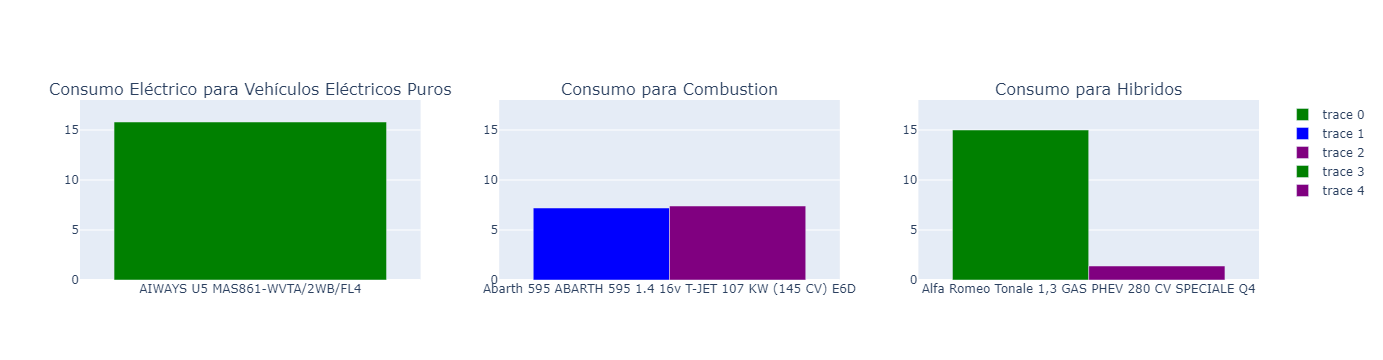

In [249]:
funcion_comparacion_seleccion_usario_modelo2(seleccionElectrico,seleccionCombustion,seleccionHibrido)

C:\Users\kihun\AppData\Local\Temp\ipykernel_5988\3879503067.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



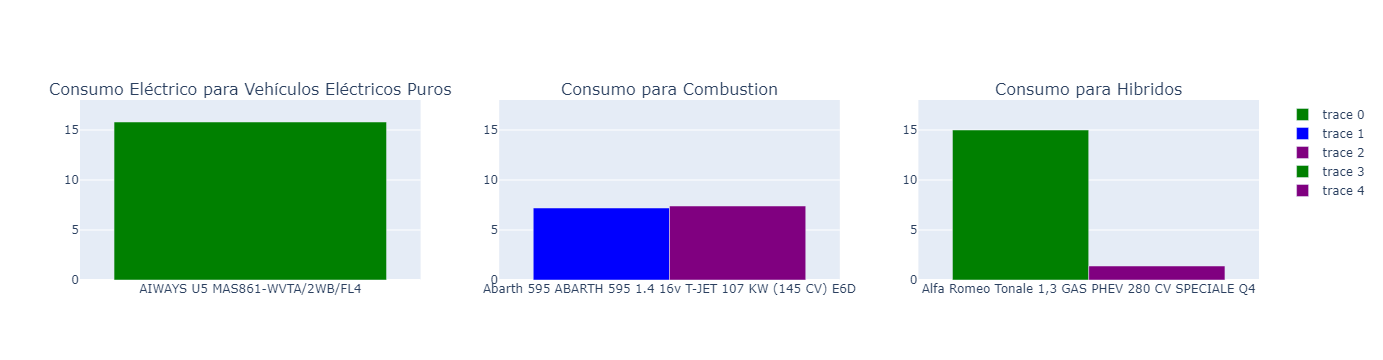

In [241]:
df_electrico = df_coches[df_coches['Modelo'] == seleccionElectrico]
df_combustion = df_coches[df_coches['Modelo'] == seleccionCombustion]
df_hibrido = df_coches[df_coches['Modelo'] == seleccionHibrido]
df_hibrido['Consumo Medio (l/100km)'] = (df_hibrido['Consumo Mínimo (l/100km)'] + df_hibrido['Consumo Máximo (l/100km)']) / 2

fig = sp.make_subplots(
    rows=1, 
    cols=3, 
    subplot_titles=['Consumo Eléctrico para Vehículos Eléctricos Puros', 'Consumo para Combustion', "Consumo para Hibridos"]
)

#--------------------------------
fig.add_trace(
    go.Bar(x=df_electrico['Modelo'], 
           y=df_electrico['Consumo Eléctrico (kWh/100km)'],
          marker_color="green"), 
    row=1, col=1
)

#--------------------------------




fig.add_trace(
    go.Bar(x=df_combustion['Modelo'], 
           y=df_combustion['Consumo Mínimo (l/100km)'],
          marker_color="blue"), 
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df_combustion['Modelo'], 
           y=df_combustion['Consumo Máximo (l/100km)'],
          marker_color="purple"), 
    row=1, col=2
)



#--------------------------------


fig.add_trace(
    go.Bar(x=df_hibrido['Modelo'], 
           y=df_hibrido['Consumo Eléctrico (kWh/100km)'],
          marker_color="green"), 
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df_hibrido['Modelo'], 
           y=df_hibrido['Consumo Medio (l/100km)'],
          marker_color="purple"), 
    row=1, col=3
)

#--------------------------------
fig.update_yaxes(range=[0, 18], row=1, col=1)
fig.update_yaxes(range=[0, 18], row=1, col=2)
fig.update_yaxes(range=[0, 18], row=1, col=3)
fig.show()

### PREDICCIONES

In [95]:
def predicion_gasolina(input_usuario_precio_gasolina_semana_corriente):
    #cargar el df con el registro de la evolucion de precios
    df = pd.read_csv("Data/Precios_Gasolina_y_Precios_Gasoleo.csv")
    #cargar el pickle con el modelo entrenado
    with open('Data/model_gasolina_pkl.pkl', 'rb') as file:
        modelo_pkl = pickle.load(file)
    #nos quedamos con las ultimas 9 instancias del modelo
    instancia = df["Precio Gasolina"][-10: -1].to_list()
    #appendeamos la nueva instancia para tener 10
    instancia.append(input_usuario_precio_gasolina_semana_corriente)
    #transformamos a array para predecir con el modelo pkl
    instancia = np.array(instancia).reshape(-1, 10, 1)
    #predecimos
    prediccion_precio = modelo_pkl.predict(instancia)
    prediccion_precio = prediccion_precio[0][0]
    #devolvemos el resultado
    return prediccion_precio

In [144]:
def predicion_gasoleo(input_usuario_precio_gasoleo_semana_corriente):
    #cargar el df con el registro de la evolucion de precios
    df = pd.read_csv("Data/Precios_Gasolina_y_Precios_Gasoleo.csv")
    #cargar el pickle con el modelo entrenado
    with open('Data/model_gasoleo_pkl.pkl', 'rb') as file:
        modelo_pkl = pickle.load(file)
    #nos quedamos con las ultimas 9 instancias del modelo
    instancia = df["Precio Gasoleo"][-10: -1].to_list()
    #appendeamos la nueva instancia para tener 10
    instancia.append(input_usuario_precio_gasoleo_semana_corriente)
    #transformamos a array para predecir con el modelo pkl
    instancia = np.array(instancia).reshape(-1, 10, 1)
    #predecimos    
    prediccion_precio = modelo_pkl.predict(instancia)
    prediccion_precio = prediccion_precio[0][0]
    #devolvemos el resultado
    return prediccion_precio

In [135]:
def predicion_gasolina_semanas(input_usuario_precio_gasolina_semana_corriente, num_semanas):
    #cargamos el df con precios y el modelo pkl  
    df = pd.read_csv("Data/Precios_Gasolina_y_Precios_Gasoleo.csv")
    with open('Data/model_gasolina_pkl.pkl', 'rb') as file:
        modelo_pkl = pickle.load(file)
    #recorremos un bucle para predecir la primera instancia, agregar esta a una nueva lista y continuar prediciendo en función de las semanas indicadas.    
    for n in range(num_semanas):
        if n == 0:
            #se hace la primera prediccion y se appe
            prediccion_precio = predicion_gasolina(input_usuario_precio_gasolina_semana_corriente) 
            instancia = df["Precio Gasolina"][-9: -1].to_list()

            instancia.append(input_usuario_precio_gasolina_semana_corriente)
            instancia.append(prediccion_precio)

        else:

            instancia_array = np.array(instancia).reshape(-1, 10, 1)
            prediccion_precio = modelo_pkl.predict(instancia_array)
            prediccion_precio = prediccion_precio[0][0]
            instancia = instancia[1:]
            instancia.append(prediccion_precio)

    return instancia[(len(instancia)-num_semanas):]

In [74]:
def predicion_gasoleo_semanas(input_usuario_precio_gasoleo_semana_corriente, num_semanas):
    #cargamos el df con precios y el modelo pkl  
    df = pd.read_csv("Data/Precios_Gasolina_y_Precios_Gasoleo.csv")
    with open('Data/model_gasoleo_pkl.pkl', 'rb') as file:
        modelo_pkl = pickle.load(file)
    #recorremos un bucle para predecir la primera instancia, agregar esta a una nueva lista y continuar prediciendo en función de las semanas indicadas.    
    for n in range(num_semanas):
        if n == 0:
            #se hace la primera prediccion y se appe
            prediccion_precio = predicion_gasoleo(input_usuario_precio_gasoleo_semana_corriente) 
            instancia = df["Precio Gasoleo"][-9: -1].to_list()

            instancia.append(input_usuario_precio_gasoleo_semana_corriente)
            instancia.append(prediccion_precio)

        else:

            instancia_array = np.array(instancia).reshape(-1, 10, 1)
            prediccion_precio = modelo_pkl.predict(instancia_array)
            prediccion_precio = prediccion_precio[0][0]
            instancia = instancia[1:]
            instancia.append(prediccion_precio)

    return instancia[(len(instancia)-num_semanas):]

In [136]:
predicion_gasolina_semanas(1.5,3)

1/1 [==============================] - 0s 18ms/step


[1.4849548, 1.4941549, 1.5152433]

### CREAR DF CON LAS PREDICCIONES

In [160]:
def funcion_crear_df_predicciones(input_usuario_precio_gasoleo_semana_corriente=None, input_usuario_precio_gasolina_semana_corriente=None, num_semanas=True):
    
    semana = [(semana + 5) for semana in range((num_semanas))]
    precios_gasolina = predicion_gasolina_semanas(input_usuario_precio_gasolina_semana_corriente, num_semanas)
    precios_gasoleo = predicion_gasoleo_semanas(input_usuario_precio_gasoleo_semana_corriente, num_semanas)
            
    df_gasolina = pd.DataFrame({"Año": 2024, "Semana": semana, "Precio Gasolina": precios_gasolina})
    df_gasolina['Fecha'] = df_gasolina.apply(lambda row: pd.to_datetime(f'{int(row["Año"])}-W{int(row["Semana"])}-1', format='%G-W%V-%u'), axis=1)
        
    df_gasoleo = pd.DataFrame({"Año": 2024, "Semana": semana, "Precio Gasoleo": precios_gasoleo})
    df_gasoleo['Fecha'] = df_gasoleo.apply(lambda row: pd.to_datetime(f'{int(row["Año"])}-W{int(row["Semana"])}-1', format='%G-W%V-%u'), axis=1)
    
    if input_usuario_precio_gasolina_semana_corriente and input_usuario_precio_gasoleo_semana_corriente:
    
        df_combinado = pd.merge(df_gasolina, df_gasoleo[['Fecha', 'Precio Gasoleo']], on='Fecha')

        return df_combinado
    
    elif input_usuario_precio_gasolina_semana_corriente:    
        
        return df_gasolina
    
    elif input_usuario_precio_gasoleo_semana_corriente:
        
        return df_gasoleo
    
    else:
        return None

### Añadir a la grafica

In [162]:
def funcion_agregado_prediccion(input_usuario_precio_gasoleo_semana_corriente = None, input_usuario_precio_gasolina_semana_corriente = None , num_semanas=True):
      
    df = pd.read_csv("data/Precios_Gasolina_y_Precios_Gasoleo.csv")
    df["Semana"] = df["Semana"].apply(lambda x: x.split(" ")[1])
    df['Fecha'] = df.apply(lambda row: pd.to_datetime(f'{int(row["Año"])}-W{int(row["Semana"])}-1', format='%G-W%V-%u'), axis=1)
    df = df[df["Año"] == 2024]  
    df_semana_final = df.loc[df.index == df.index[-1]]
    df_combinado = funcion_crear_df_predicciones(input_usuario_precio_gasoleo_semana_corriente,input_usuario_precio_gasolina_semana_corriente,num_semanas)

    if input_usuario_precio_gasolina_semana_corriente and input_usuario_precio_gasoleo_semana_corriente:
 
        fig = px.line(data_frame=df, 
                      x="Fecha", 
                      y=["Precio Gasoleo","Precio Gasolina"],
                      labels={"value": "Precio", "variable": "Tipo de Combustible"},
                      color_discrete_map={"Precio Gasolina": "blue", "Precio Gasoleo": "red"})
        
    
        df_combinado = pd.concat([df_semana_final,df_combinado], axis=0)
        
        traza_prediccion_gasoleo = px.line(df_combinado, x="Fecha", y="Precio Gasoleo",)
        traza_prediccion_gasoleo.data[0].line.color = "purple"  
        traza_prediccion_gasolina = px.line(df_combinado, x="Fecha", y="Precio Gasolina",)
        traza_prediccion_gasolina.data[0].line.color = "magenta"  

        # Agregar la traza de la predicción al gráfico
        fig.add_trace(traza_prediccion_gasoleo.data[0])
        fig.add_trace(traza_prediccion_gasolina.data[0])
        fig.show()
  
    elif input_usuario_precio_gasolina_semana_corriente:
 
        fig = px.line(data_frame=df, 
                      x="Fecha", 
                      y=["Precio Gasolina"],
                      labels={"value": "Precio", "variable": "Tipo de Combustible"},
                      color_discrete_map={"Precio Gasolina": "blue", "Precio Gasoleo": "red"})
        

        df_combinado = pd.concat([df_semana_final,df_combinado], axis=0)

        traza_prediccion_gasolina = px.line(df_combinado, x="Fecha", y="Precio Gasolina",)
        traza_prediccion_gasolina.data[0].line.color = "magenta" 
        
        fig.add_trace(traza_prediccion_gasolina.data[0])
        fig.show()

    elif input_usuario_precio_gasoleo_semana_corriente:

        fig = px.line(data_frame=df, 
                      x="Fecha", 
                      y=["Precio Gasoleo"],
                      labels={"value": "Precio", "variable": "Tipo de Combustible"},
                      color_discrete_map={"Precio Gasolina": "blue", "Precio Gasoleo": "red"})
        
    
        df_combinado = funcion_crear_df_predicciones(input_usuario_precio_gasoleo_semana_corriente,num_semanas)
        df_combinado = pd.concat([df_semana_final,df_combinado], axis=0)
  
        traza_prediccion_gasoleo = px.line(df_combinado, x="Fecha", y="Precio Gasoleo",)
        traza_prediccion_gasoleo.data[0].line.color = "magenta" 
        
        fig.add_trace(traza_prediccion_gasoleo.data[0])
        fig.show()


In [119]:
def funcion_line_precio():
    df = pd.read_csv("../data/Precios_Gasolina_y_Precios_Gasoleo.csv")
    df["Semana"] = df["Semana"].apply(lambda x: x.split(" ")[1])
    df['Fecha'] = df.apply(lambda row: pd.to_datetime(f'{int(row["Año"])}-W{int(row["Semana"])}-1', format='%G-W%V-%u'), axis=1)

    fig = px.line(data_frame=df, 
                  x="Fecha", 
                  y=["Precio Gasolina", "Precio Gasoleo"],
                  labels={"value": "Precio", "variable": "Tipo de Combustible"},
                  color_discrete_map={"Precio Gasolina": "blue", "Precio Gasoleo": "red"})
    fig.show()

In [132]:
funcion_crear_df_predicciones

<function __main__.funcion_crear_df_predicciones(input_usuario_precio_gasoleo_semana_corriente=None, input_usuario_precio_gasolina_semana_corriente=None, num_semanas=True)>

###PREDICCIONES EMISIONES

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [101]:
df_coches = pd.read_csv("../data/df_coches_escrapeo.csv")

In [102]:
consumo_emisiones_gasolina = df_coches[df_coches["Motorización"]=="Gasolina"]	

consumo_emisiones_gasolina = consumo_emisiones_gasolina[['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)', 'Emisiones Mínimo', 'Emisiones Máximo']]
# Suponiendo que tienes tus datos en un DataFrame de pandas llamado 'consumo_emisiones_gasolina'
# Asegúrate de tener las columnas de 'Consumo Mínimo', 'Consumo Máximo', 'Emisiones Mínimo', 'Emisiones Máximo'

# Vamos a usar el promedio entre el consumo mínimo y máximo como nuestra variable independiente
consumo_emisiones_gasolina['Consumo Promedio'] = (consumo_emisiones_gasolina['Consumo Mínimo (l/100km)'] + consumo_emisiones_gasolina['Consumo Máximo (l/100km)']) / 2

# Definimos las variables de entrada (X) y la variable de salida (y)
X = consumo_emisiones_gasolina[['Consumo Promedio']]
y = consumo_emisiones_gasolina['Emisiones Máximo']

# Dividimos los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Creamos el modelo de regresión lineal
modelo = LinearRegression()

# Ajustamos el modelo a los datos de entrenamiento
modelo.fit(X_train, y_train)

# Hacemos predicciones sobre los datos de prueba
predicciones = modelo.predict(X_test)

# Evaluamos el rendimiento del modelo
score_entrenamiento = modelo.score(X_train, y_train)
score_prueba = modelo.score(X_test, y_test)

print(f'Rendimiento del modelo en el conjunto de entrenamiento: {score_entrenamiento}')
print(f'Rendimiento del modelo en el conjunto de prueba: {score_prueba}')


Rendimiento del modelo en el conjunto de entrenamiento: 0.9657687104788377
Rendimiento del modelo en el conjunto de prueba: 0.9468043887353599


In [103]:
with open('modelo_emisiones_gasolina.pkl', 'wb') as archivo:
    pickle.dump(modelo, archivo)

In [107]:
with open('../Data/modelo_emisiones_gasolina.pkl', 'rb') as file:
    modelo_pkl = pickle.load(file)

In [113]:
input_consumo = int(input("consumo en litros cada 100km"))
df_consumo = pd.DataFrame({"Consumo Promedio":[input_consumo]})
prediccion = modelo.predict(df_consumo)

consumo en litros cada 100km 5


In [115]:
prediccion[0]

136.33779355896988

In [104]:
consumo_emisiones_gasoil = df_coches[df_coches["Motorización"]=="Gasóleo"]	

consumo_emisiones_gasoil = consumo_emisiones_gasoil[['Consumo Mínimo (l/100km)', 'Consumo Máximo (l/100km)', 'Emisiones Mínimo', 'Emisiones Máximo']]
# Suponiendo que tienes tus datos en un DataFrame de pandas llamado 'consumo_emisiones_gasolina'
# Asegúrate de tener las columnas de 'Consumo Mínimo', 'Consumo Máximo', 'Emisiones Mínimo', 'Emisiones Máximo'

# Vamos a usar el promedio entre el consumo mínimo y máximo como nuestra variable independiente
consumo_emisiones_gasoil['Consumo Promedio'] = (consumo_emisiones_gasoil['Consumo Mínimo (l/100km)'] + consumo_emisiones_gasoil['Consumo Máximo (l/100km)']) / 2
consumo_emisiones_gasoil.dropna(inplace=True)
# Definimos las variables de entrada (X) y la variable de salida (y)
X = consumo_emisiones_gasoil[['Consumo Promedio']]
y = consumo_emisiones_gasoil['Emisiones Máximo']

# Dividimos los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Creamos el modelo de regresión lineal
modelo = LinearRegression()

# Ajustamos el modelo a los datos de entrenamiento
modelo.fit(X_train, y_train)

# Hacemos predicciones sobre los datos de prueba
predicciones = modelo.predict(X_test)

# Evaluamos el rendimiento del modelo
score_entrenamiento = modelo.score(X_train, y_train)
score_prueba = modelo.score(X_test, y_test)

print(f'Rendimiento del modelo en el conjunto de entrenamiento: {score_entrenamiento}')
print(f'Rendimiento del modelo en el conjunto de prueba: {score_prueba}')

Rendimiento del modelo en el conjunto de entrenamiento: 0.904823323029897
Rendimiento del modelo en el conjunto de prueba: 0.8995285265216839


In [105]:
with open('modelo_emisiones_gasoil.pkl', 'wb') as archivo:
    pickle.dump(modelo, archivo)